## Imports and Installations

In [ ]:
from google.cloud import storage
from google.cloud.storage import transfer_manager
from google.colab import auth
from io import BytesIO
import unittest
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd
import rasterio

## Authenticate to GCP and Establish Bucket ID

In [ ]:
auth.authenticate_user()

In [ ]:
project_id = "silicon-cell-471722-a4"
bucket_name = "firespreadpredictiontest"
!gcloud config set project {project_id}

Updated property [core/project].


## The Dataset Class (Dun Dun Duuuuun 🎵)


In [ ]:
from google.cloud import storage
class FireDataset():
    def __init__(self, project_id, bucket_id, dataset = None):
        self.project = project_id
        self.bucket = bucket_id
        self.storage_client = storage.Client()
        self.ds_prefixes = []
        self.selected_dataset = dataset;
        self.ds_blobs = []
        # If data is downloaded
        self.local_path = None
        if dataset:
            self.select_dataset(dataset)
        # For creating the pytorch dataset from tensors
        self.samples = []
        self.labels = []
        # Vital statistics for EDA
        self.vital_statistics = {}

    def extract_prefix(self, filename, delimiter, folder_name = None):
        """
        Helper function to extract the prefix of a filename before a delimiter.
        Returns the prefix unless said prefix ends with ".txt", in which case
        returns None.
        """
        if folder_name:
            folder_name = folder_name + "/"
            try:
                filename = filename.replace(folder_name, "")
            except:
                pass
        pref = filename.split(delimiter)[0]
        return None if "." in pref else pref

    def extract_subfolders(self, prefix=None, delimiter=None):
        """
        Extract "subfolders" from the bucket specified at class creation.
        """
        blobs = self.storage_client.list_blobs(self.bucket,
            prefix=prefix, delimiter=delimiter)
        blob_list = list([blob.name for blob in blobs])
        if not delimiter:
            delimiter = "/"
        return sorted(set(x for x in set([self.extract_prefix(filename,
                delimiter, folder_name = prefix)
            for filename in blob_list]) if x is not None))

    def select_dataset(self, dataset):
        """
        Select one of the three datsets we have in the bucket for further
        retrieval/processing.
        """
        self.ds_prefixes = self.extract_subfolders()
        if dataset not in self.ds_prefixes:
            raise ValueError(f"Dataset {dataset} is not present in this bucket.")
        else:
            self.selected_dataset = dataset;

    def get_year_from_blob(self, blob_name):
        """
        Gets year from a blob name formatted thusly:
        dataset/year/fire_id/YYYY_MM_DD.tif
        """
        parts = blob_name.split("/")
        year = parts[1]
        return year

    def get_ds_blobs(self, exclude_years = None):
        """
        exclude_years is a list of strings
        """
        if not self.selected_dataset:
            return
        else:
            blobs = self.storage_client.list_blobs(self.bucket,
                                                   prefix=self.selected_dataset)
            if not exclude_years:
                self.ds_blobs = list(blob.name for blob in blobs)
            else:
                all_ds_blobs = list(blob.name for blob in blobs)
                self.ds_blobs = [blob for blob in all_ds_blobs
                                 if self.get_year_from_blob(blob) not in exclude_years]


    def download_dataset_concurrently(self, dest, max_workers = 8):
        """
        Adapted (barely) from https://cloud.google.com/storage/docs/downloading-objects
        Downloads dataset tiff files
        """
        if len(self.ds_blobs) < 1:
            print("No blobs to download.")
            return
        else:
            print(f"Preparing to download {len(self.ds_blobs)} files")

        data_bucket = self.storage_client.bucket(self.bucket)
        total_files_downloaded = 0
        results = transfer_manager.download_many_to_path(
            data_bucket,
            self.ds_blobs,
            destination_directory = dest,
            max_workers = max_workers
        )
        for name, result in zip(self.ds_blobs, results):
            if isinstance(result, Exception):
                print(f"Failed to download {name} due to {result}\n")
            else:
                total_files_downloaded += 1
        print(f"Downloaded {total_files_downloaded} files to {dest}\n")
        self.local_path = dest

    def upload_dataset_concurrently(self, dir,
                                    destination_prefix = "", max_workers = 8):
        """
        More or less stolen from:
        https://cloud.google.com/storage/docs/uploading-objects
        """
        all_files = []
        for root, dirs, files in os.walk(dir):
            for file in files:
                full_path = os.path.join(root, file)
                relative_path = os.path.relpath(full_path, dir)
                all_files.append(relative_path)
        print(f"Preparing to upload {len(all_files)} files")
        bucket = self.storage_client.bucket(self.bucket)
        blob_name_to_source = {}
        for file in all_files:
            blob_name = f"{destination_prefix.rstrip('/')}/{file}" if destination_prefix else file
            source_path = os.path.join(dir, file)
            blob_name_to_source[blob_name] = source_path

        results = transfer_manager.upload_many_from_filenames(
            bucket,
            blob_name_to_source,
            max_workers=max_workers
        )

        total_uploaded = 0
        for blob_name, result in zip(blob_name_to_source.keys(), results):
            if isinstance(result, Exception):
                print(f"Failed to upload {blob_name} due to exception: {result}")
            else:
                total_uploaded += 1

        print(f"Uploaded {total_uploaded} files to '{destination_prefix}'")


    def add_label(self, file_path, label_file_path, prev_file_path = None):
        """
        Add next day's fire mask (last band of label file)
        to a given sample.
        """
        with rasterio.open(file_path) as sample_img:
            sample = sample_img.read()
            sample_profile = sample_img.profile.copy()
            band_descriptions = list(sample_img.descriptions)

        with rasterio.open(label_file_path) as label_img:
            label = label_img.read(label_img.count)

        has_drought = "drought_index" in band_descriptions

        if not has_drought and prev_file_path is not None:
            with rasterio.open(prev_file_path) as prev_img:
                prev_descriptions = list(prev_img.descriptions)
                if "drought_index" in prev_descriptions:
                    drought_idx = prev_descriptions.index("drought_index")
                    drought_band = prev_img.read(drought_idx + 1)
                    sample = np.insert(sample, drought_idx, drought_band, axis=0)
                    band_descriptions.insert(drought_idx, "drought_index")

        elif not has_drought and not prev_file_path:
            with rasterio.open(label_file_path) as next_img:
                next_descriptions = list(next_img.descriptions)
                if "drought_index" in next_descriptions:
                    drought_idx = next_descriptions.index("drought_index")
                    drought_band = next_img.read(drought_idx + 1)
                    sample = np.insert(sample, drought_idx, drought_band, axis=0)
                    band_descriptions.insert(drought_idx, "drought_index")

        sample_with_label = np.concatenate(
            [sample, label[np.newaxis, :, :]], axis=0)
        sample_profile.update(count=sample_with_label.shape[0])
        band_descriptions.append("label")
        assert(len(band_descriptions) == 19)
        return sample_with_label, sample_profile, band_descriptions


    def process_fire_local(self, fire_path, dest):
        file_list = sorted(os.listdir(fire_path))
        fire_duration = len(file_list)
        for idx, (curr_file, next_file) in enumerate(zip(file_list[:-1], file_list[1:])):
            file_path = os.path.join(fire_path, curr_file)
            label_path = os.path.join(fire_path, next_file)
            prev_path = os.path.join(fire_path, file_list[idx - 1]) if idx > 0 else None
            processed, profile, band_descriptions = self.add_label(
                file_path, label_path, prev_path
            )
            parts = fire_path.split('/')
            year = parts[-2]
            fire_id = parts[-1]
            output_dir = os.path.join(dest, year, fire_id)
            os.makedirs(output_dir, exist_ok=True)
            processed_filename = os.path.join(output_dir, curr_file)
            with rasterio.open(processed_filename, 'w', **profile) as dst:
                dst.write(processed)
                for i, desc in enumerate(band_descriptions, start=1):
                    dst.set_band_description(i, desc)
        samples_processed = fire_duration - 1
        print(f"Processed {samples_processed} samples!")
        return fire_duration - 8, samples_processed

    def get_fire_image_shapes(self, fire_path):
        file_list = os.listdir(path = fire_path)
        this_fire = list(fire_path.split("/"))[-1]
        inconsistent = False
        rows = []
        for file in file_list:
            file_path = os.path.join(fire_path, file)

            try:
                with rasterio.open(file_path) as src:
                    img_bands = src.count
                    img_height = src.height
                    img_width = src.width

                    row = {
                        "fire": this_fire,
                        "height": img_height,
                        "width": img_width,
                        "bands": img_bands,
                        "filename": file_path
                    }
                    rows.append(row)
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")
                continue
        return rows

    def process_dataset(self, dest, validation = False, exclude_years = None):
        """
        Blobs must be named as follows:
        dataset/year/fire_id/YYYY_MM_DD.tif

        Appends tif files (EXCEPT LAST ONE FOR A GIVEN FIRE EVENT) to labels and
        next day's fire mask to labels
        """
        if not self.selected_dataset:
            print("Please select a dataset with [dataset].select_dataset(dataset_prefix)\n")
            return
        years = self.extract_subfolders(prefix = self.selected_dataset)
        if exclude_years:
            years = [year for year in years if year not in exclude_years]
        self.vital_statistics["fire_count"] = {}
        total_samples = 0
        self.vital_statistics["samples"] = 0
        self.vital_statistics["fire_durations"] ={}
        sample_shapes = []
        for year in years:
            year_path = self.selected_dataset + "/" + year
            fires = self.extract_subfolders(prefix = year_path)
            self.vital_statistics["fire_count"][year] = len(fires)
            fire_paths = [year_path + "/" + fire for fire in fires]

            for fire in fire_paths:
                if self.local_path:
                    sample_shapes.extend(self.get_fire_image_shapes(
                         f"{self.local_path}/{fire}"))
                    duration, samples = self.process_fire_local(
                        self.local_path + "/" + fire, dest)
                    fire_id = fire.split("/")[-1]
                    self.vital_statistics["fire_durations"][fire] = duration
                    self.vital_statistics["samples"] += 1

        self.vital_statistics["fire_count"]["total"] = sum([ct for yr, ct
                                in self.vital_statistics["fire_count"].items()])
        print(self.vital_statistics)
        updated_shape_data = pd.DataFrame(sample_shapes)
        return updated_shape_data


In [ ]:
ds = FireDataset(project_id=project_id, bucket_id=bucket_name,
                 dataset="bc_wildfire")
ds.local_path = "/content/data"

In [ ]:
ds.get_ds_blobs()

In [ ]:
! rm -r /content/processed_data

rm: cannot remove '/content/processed_data': No such file or directory


In [ ]:
ds.download_dataset_concurrently(ds.local_path)

Preparing to download 8577 files
Downloaded 8577 files to /content/data



In [ ]:
shape_data = ds.process_dataset("/content/processed_data/bc_wildfire")

Processed 17 samples!
Processed 21 samples!
Processed 11 samples!
Processed 46 samples!
Processed 25 samples!
Processed 19 samples!
Processed 12 samples!
Processed 12 samples!
Processed 18 samples!
Processed 23 samples!
Processed 19 samples!
Processed 31 samples!
Processed 25 samples!
Processed 30 samples!
Processed 29 samples!
Processed 20 samples!
Processed 20 samples!
Processed 26 samples!
Processed 20 samples!
Processed 20 samples!
Processed 21 samples!
Processed 19 samples!
Processed 27 samples!
Processed 27 samples!
Processed 19 samples!
Processed 15 samples!
Processed 24 samples!
Processed 18 samples!
Processed 22 samples!
Processed 27 samples!
Processed 20 samples!
Processed 17 samples!
Processed 81 samples!
Processed 14 samples!
Processed 29 samples!
Processed 20 samples!
Processed 57 samples!
Processed 53 samples!
Processed 22 samples!
Processed 52 samples!
Processed 40 samples!
Processed 16 samples!
Processed 17 samples!
Processed 26 samples!
Processed 21 samples!
Processed 

In [ ]:
import json
with open('/content/processed_data/bc_wildfire/updated_stats.json', 'w') as fp:
    json.dump(ds.vital_statistics, fp)

In [ ]:
ds.upload_dataset_concurrently("/content/processed_data", "processed_data")

Preparing to upload 8280 files
Uploaded 8280 files to 'processed_data'


## Dimensional Inconsistencies



In [ ]:
# shape_data = pd.read_csv('/content/data/bc_wildfire/tiff_shapes.csv')

In [ ]:
shape_data.head()

,fire,height,width,bands,filename
0,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...
1,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...
2,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...
3,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...
4,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...


In [ ]:
shape_data['date'] = pd.to_datetime(
    shape_data['filename'].str.extract(r'(\d{4}-\d{2}-\d{2})\.tif$')[0])
shape_data["year"] = shape_data["date"].dt.year
shape_data["month"] = shape_data["date"].dt.month
shape_data["day"] = shape_data["date"].dt.day

I confirmed that we don't have any fires that "wrap around" from december to january of the next year. In fact, we don't have any fires in Juanuary or February.

In [ ]:
shape_data.head()

,fire,height,width,bands,filename,date,year,month,day
0,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...,2012-04-21,2012,4,21
1,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...,2012-04-28,2012,4,28
2,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...,2012-04-16,2012,4,16
3,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...,2012-04-20,2012,4,20
4,fire_14659039,171,172,18,/content/data/bc_wildfire/2012/fire_14659039/2...,2012-04-30,2012,4,30


In [ ]:
shape_data[shape_data["month"] == 1].shape

(0, 9)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=shape_data)

https://docs.google.com/spreadsheets/d/1BL-DXElP1YEK5_d7Nu3lyr-brhs3kG7vIS1AlPFFxnM/edit#gid=0


In [ ]:
shape_data.shape

(8574, 9)

In [ ]:
shape_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8574 entries, 0 to 8573
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fire      8574 non-null   object        
 1   height    8574 non-null   int64         
 2   width     8574 non-null   int64         
 3   bands     8574 non-null   int64         
 4   filename  8574 non-null   object        
 5   date      8574 non-null   datetime64[ns]
 6   year      8574 non-null   int32         
 7   month     8574 non-null   int32         
 8   day       8574 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(3), object(2)
memory usage: 502.5+ KB


In [ ]:
bucket = ds.storage_client.get_bucket(ds.bucket)
bucket.blob('bc_wildfire/updated_tiff_shapes.csv').upload_from_string(
    shape_data.to_csv(), "updated_tiff_shapes.csv")

### Band Number Inconsistencies

In [ ]:
sheet = sheets.InteractiveSheet(df=shape_data[shape_data["bands"] == 17])

https://docs.google.com/spreadsheets/d/1ErwlbYCaXsmkZmXSNxvPNC5TV71JTQXskPwefow2wNI/edit#gid=0


In [ ]:
max(shape_data["bands"])

18

In [ ]:
first_of_month = shape_data[shape_data["day"]==1]
first_of_month.head()

,fire,height,width,bands,filename,date,year,month,day
52,fire_14918632,171,172,18,/content/data/bc_wildfire/2012/fire_14918632/2...,2012-07-01,2012,7,1
68,fire_14918632,171,172,17,/content/data/bc_wildfire/2012/fire_14918632/2...,2012-08-01,2012,8,1
108,fire_14918640,172,171,17,/content/data/bc_wildfire/2012/fire_14918640/2...,2012-08-01,2012,8,1
131,fire_14918646,172,172,17,/content/data/bc_wildfire/2012/fire_14918646/2...,2012-08-01,2012,8,1
256,fire_15046665,171,172,17,/content/data/bc_wildfire/2012/fire_15046665/2...,2012-09-01,2012,9,1


In [ ]:
filtered = shape_data[shape_data["bands"] == 17]
filtered_fires = set(filtered["fire"])
hypothesis_test = shape_data[shape_data["fire"].isin(filtered_fires)]
hypothesis_test = hypothesis_test[hypothesis_test["day"].isin([28,30,31,1,2])]

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=hypothesis_test.sort_values(["fire", "date"]))

https://docs.google.com/spreadsheets/d/1qbfd3dIhKSaf2vziTfN_T81TY96ASGuku4YXo6o4Ql8/edit#gid=0


Not all samples from the first of the month have only 17 bands, but all samples with only 17 bands were taken on the first of the month. Are they all missing the same feature?

In [ ]:
expected_bands = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last',
                  'total precipitation', 'wind speed', 'wind direction',
                  'minimum temperature', 'maximum temperature',
                  'energy release component', 'specific humidity',
                  'slope', 'aspect', 'elevation', 'drought_index',
                  'land_cover', 'active fire']
missing_band = shape_data[shape_data["bands"] == 17]
filenames = list(missing_band["filename"])

missing_band_dict = {}

for file in filenames:
    with rasterio.open(file) as src:
        sample = src.read()
        band_descriptions = [src.descriptions[i] for i in range(src.count)]
        height = src.height
        width = src.width
        bands = src.count
    missing_band_dict[file] = [desc for desc in expected_bands
                                   if desc not in band_descriptions]


In [ ]:
missing_band_dict.values()

dict_values([['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'], ['drought_index'],

It's always drought index.

### Width/Height Inconsistencies

In [ ]:
fires = set(shape_data["fire"])

res = shape_data.groupby("fire").agg({
    "height": ["min", "max"],
    "width": ["min", "max"]
})
res.columns = ['_'.join(col).strip() for col in res.columns.values]
result = res.reset_index()
res["consistent?"] = ((res["height_min"] == res["height_max"])
                      & (res["width_min"] == res["width_max"]))

In [ ]:
res.shape

(295, 5)

In [ ]:
res[res['consistent?'] == False]

,height_min,height_max,width_min,width_max,consistent?
fire,,,,,


In [ ]:
res[res['consistent?'] == True].shape

(295, 5)

In [ ]:
res

,height_min,height_max,width_min,width_max,consistent?
fire,,,,,
fire_14659039,171,171,172,172,True
fire_14659047,171,171,171,171,True
fire_14918627,172,172,172,172,True
fire_14918632,171,171,172,172,True
fire_14918640,172,172,171,171,True
...,...,...,...,...,...
fire_25411390,172,172,171,171,True
fire_25411428,172,172,171,171,True
fire_25413143,172,172,171,171,True


As far as I can tell, there are no height/width inconsistencies within individual fire events. Let's see how much dimensions vary among fire events.

In [ ]:
print(f"""
    Minimum width: {min(res['width_min'])}
    Maximum width: {max(res['width_max'])}
    Minimum height: {min(res['height_min'])}
    Maximum height: {max(res['height_max'])}
    """)


    Minimum width: 171
    Maximum width: 172
    Minimum height: 171
    Maximum height: 172
    


I think a one-pixel discrepancy won't be too much of an issue to pad out. I'll add dummy values around the "edge" of the image when needed.

## downloading data from google storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = "silicon-cell-471722-a4"
bucket_name = "firespreadpredictiontest"

!gcloud config set project {project_id}

local_folder = "/content/bc_wildfire"
!mkdir -p {local_folder}

remote_prefix = "bc_wildfire"

print("⏳ Downloading wildfire dataset from Google Cloud Storage...")
!gsutil -m cp -r gs://{bucket_name}/{remote_prefix}/* {local_folder}/

print("✅ Download complete!")
print(f"Local data is now stored in: {local_folder}")
!ls -R {local_folder}


Streaming output truncated to the last 5000 lines.
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-24.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-25.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-26.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-27.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-28.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999218/2018-08-29.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999235/2018-08-07.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999235/2018-08-08.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999235/2018-08-09.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999235/2018-08-10.tif...
Copying gs://firespreadpredictiontest/bc_wildfire/2018/fire_21999235/2018-08-11

## Messing Around with a Single Image

In [ ]:
filename = "/content/data/bc_wildfire/2014/fire_17349060/2014-08-01.tif"

In [ ]:
with rasterio.open(filename) as src:
    sample = src.read()
    band_descriptions = [src.descriptions[i] for i in range(src.count)]
    height = src.height
    width = src.width
    bands = src.count

In [ ]:
print(height, width, bands)

172 172 17


In [ ]:
type(sample)

numpy.ndarray

In [ ]:
expected_bands = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'drought_index', 'land_cover', 'active fire']

In [ ]:
print(band_descriptions)

['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'land_cover', 'active fire']


In [ ]:
aa = [band for band in expected_bands if band not in band_descriptions]

In [ ]:
len(band_descriptions)

17

In [ ]:
len(list(set(expected_bands) & set(band_descriptions)))

17

In [ ]:
aa

['drought_index']

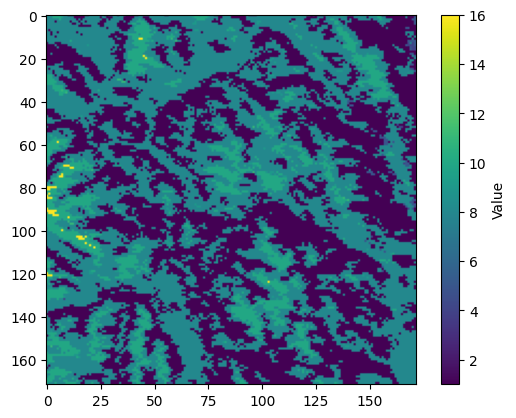

In [ ]:
import matplotlib.pyplot as plt

band = sample[15, :, :]

fig, ax = plt.subplots()
im = ax.imshow(band)
plt.colorbar(im, ax=ax, label='Value')
plt.show()

## Torch Dataset Class Prototype

In [ ]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from typing import Literal
from google.cloud import storage

ALL_YEARS = ['2012',
            '2013',
            '2014',
            '2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021']

EXPECTED_BANDS = 19
EXPECTED_WIDTH = 172
EXPECTED_HEIGHT = 172

def get_year_from_blob(blob_name):
    """
    Gets year from a blob name formatted thusly:
    year/fire_id/YYYY_MM_DD.tif
    """
    parts = blob_name.split("/")
    year = parts[0]
    return year

def get_all_files(dir: str, years="all", client=None):
    if years == "all":
        years = ALL_YEARS

    mode = "gcloud" if dir.startswith("gs://") else "local"

    if mode == "gcloud":
        if not client:
            client = storage.Client()
        bucket_name, prefix = dir.replace("gs://", "").split("/", 1)
        bucket = client.bucket(bucket_name)
        blobs = bucket.list_blobs(prefix=prefix)
        all_files = [blob.name[len(prefix):].lstrip("/")
                     for blob in blobs
                     if blob.name.lower().endswith(('.tif', '.tiff'))]
    else:
        all_files = []
        for root, _, files in os.walk(dir):
            for file in files:
                if file.lower().endswith(('.tif', '.tiff')):
                    full_path = os.path.join(root, file)
                    all_files.append(os.path.relpath(full_path, dir))

    return [f for f in all_files if get_year_from_blob(f) in years]


class FirePredDataset(Dataset):
    def __init__(self,
                 dataset_dir: str,
                 years="all",
                 transform=None,
                 mode: Literal["train", "val", "test"] = "train"):
        self.dataset_dir = dataset_dir
        self.years = ALL_YEARS if years == "all" else years
        self.file_location = "gcloud" if dataset_dir.startswith("gs://") else "local"
        self.client = storage.Client() if self.file_location == "gcloud" else None
        self.sample_files = get_all_files(self.dataset_dir, self.years, self.client)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.sample_files)

    def __getitem__(self, idx: int):
        """
        A single sample is a single tiff file where target is the target band,
        labeled "label".
        (should always be the last band)
        """
        if self.file_location == "local":
            img_file = os.path.join(self.dataset_dir, self.sample_files[idx])
        else:
            bucket_name, prefix = self.dataset_dir.replace("gs://", "").split("/", 1)
            img_file = f"gs://{bucket_name}/{prefix}/{self.sample_files[idx]}"

        with rasterio.open(img_file) as src:
            item = src.read()
            item_bands = [src.descriptions[i] for i in range(src.count)]
            item_height = src.height
            item_width = src.width

            # Quick dimension padding/validation
            if item_height < EXPECTED_HEIGHT:
                rows_to_add = EXPECTED_HEIGHT - item_height
                bottom_row = item[:, -1:, :]
                item = np.concatenate(
                    [item] + [bottom_row] * rows_to_add, axis=1)
            if item_width < EXPECTED_WIDTH:
                cols_to_add = EXPECTED_WIDTH - item_width
                rightmost_col = item[:, :, -1:]
                item = np.concatenate(
                    [item] + [rightmost_col] * cols_to_add, axis=2)
            if len(item_bands) != EXPECTED_BANDS:
                raise Exception(f"{img_file} has {len(item_bands)} bands, expected 19.")
            if item_width > EXPECTED_WIDTH or item_height > EXPECTED_HEIGHT:
                raise Exception(f"{img_file} is too large. Max size is 172x172 px")

        label_idx = item_bands.index("label")

        band_indices = [i for i in range(len(item_bands)) if i != label_idx]

        x = item[band_indices, :, :]
        x = torch.from_numpy(x)
        x_bands = [item_bands[i] for i in band_indices]

        y = item[label_idx, :, :]
        y = torch.from_numpy(y)
        y_bands = ["label"]

        # Not sure if transformations we'll be doing will also need to be
        # applied to the label??
        if self.transform:
            x = self.transform(x)

        return x, x_bands, y, y_bands

In [ ]:
data = FirePredDataset(dataset_dir = "gs://firespreadpredictiontest/processed_data/bc_wildfire")
x, x_bands, y, y_bands = data.__getitem__(8001)
print(x.shape)

torch.Size([18, 172, 172])


In [ ]:
x_bands

['M11',
 'I2',
 'I1',
 'NDVI_last',
 'EVI2_last',
 'total precipitation',
 'wind speed',
 'wind direction',
 'minimum temperature',
 'maximum temperature',
 'energy release component',
 'specific humidity',
 'slope',
 'aspect',
 'elevation',
 'drought_index',
 'land_cover',
 'active fire']

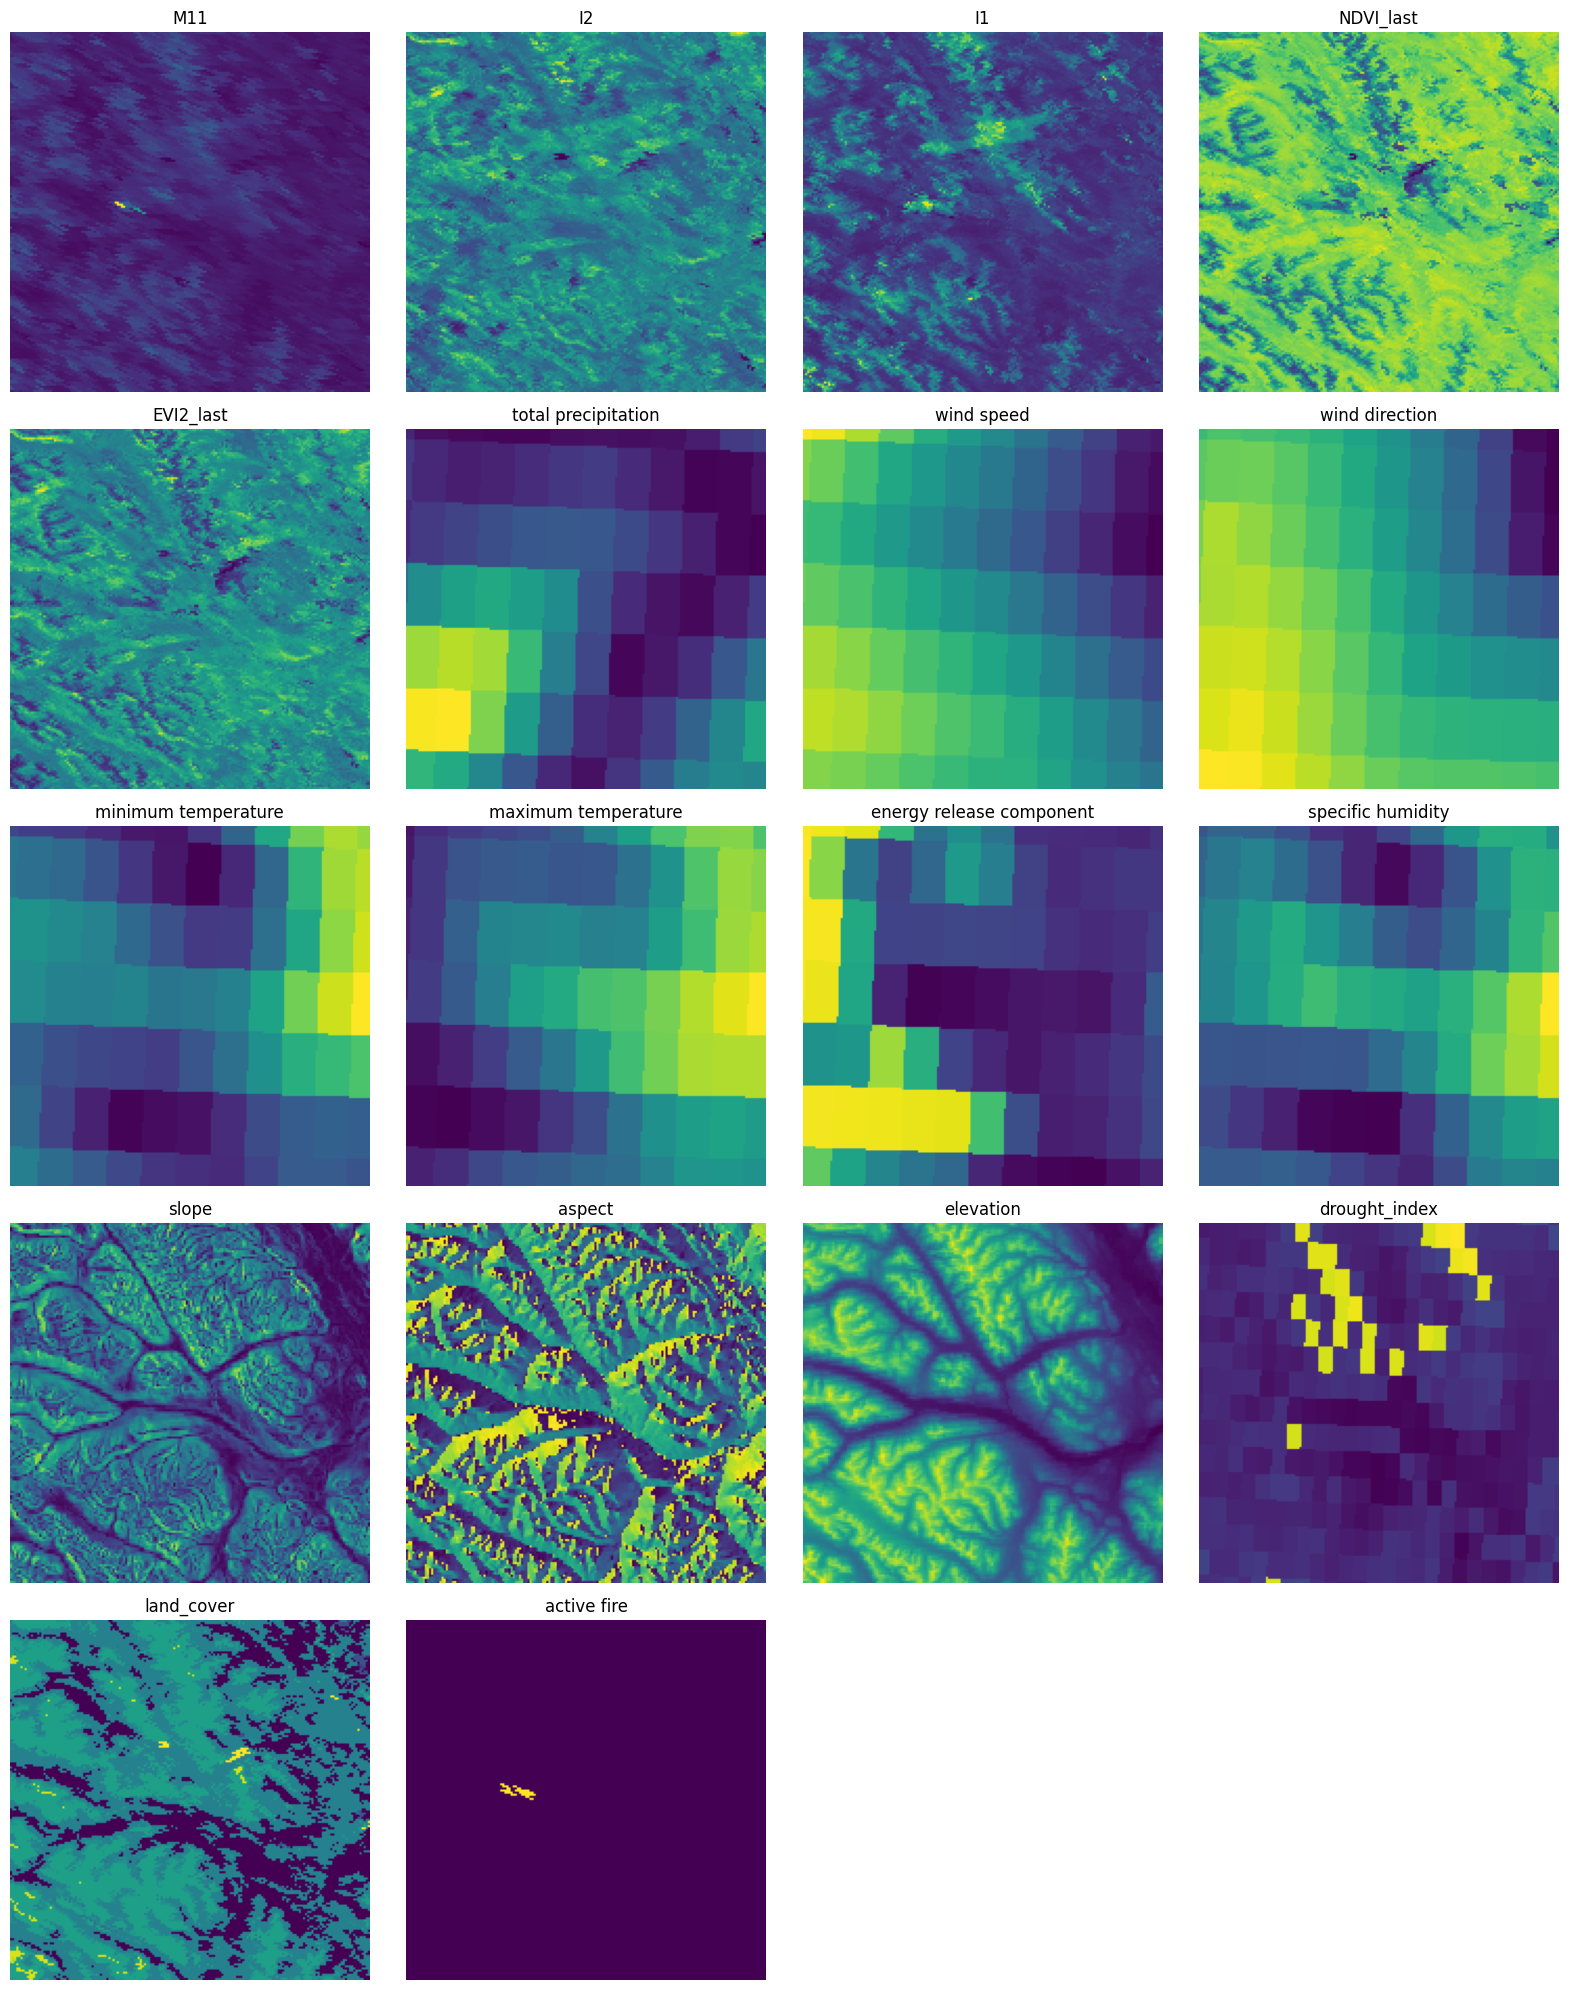

In [ ]:
import matplotlib.pyplot as plt

num_bands = x.shape[0]
cols = 4
rows = (num_bands + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()

for i in range(num_bands):
    band = x[i, :, :]
    axes[i].imshow(band, cmap='viridis')
    axes[i].set_title(x_bands[i] if i < len(x_bands) else f'Band {i+1}')
    axes[i].axis('off')

# Hide unused subplots
for i in range(num_bands, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## CNN tranfer training model

### retrieving data from GSC

In [ ]:
# loading data from GSC
from google.colab import auth
auth.authenticate_user()

project_id = "silicon-cell-471722-a4"
bucket_name = "firespreadpredictiontest"
!gcloud config set project {project_id}

# save to local
local_base = "/content/processed_data"
!mkdir -p {local_base}
splits = ["train", "val", "test"]

for split in splits:
    print(f"Downloading {split} ...")
    !gsutil -m cp -r gs://{bucket_name}/processed_data/bc_wildfire/{split} {local_base}/
    print(f"Done: {split}\n")

print("All splits downloaded!")


Streaming output truncated to the last 5000 lines.
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-07-27.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-07-28.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-07-30.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-07-31.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-08-05.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-08-06.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-08-07.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_21891317/2018-08-08.tif...
Copying gs://firespreadpredictiontest/processed_data/bc_wildfire/train/2018/fire_2189

### load the pretrained model

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def build_CNN_AE_model() -> Model:
    """
    Create CNN auto encode model.

    Returns:
        (Model): Keras model.
    """
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12],
                                                   include_top=False,
                                                   weights=None)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 32x32
        'block_3_expand_relu',   # 16x16
        'block_6_expand_relu',   # 8x8
        'block_13_expand_relu',  # 4x4
        'block_16_project',      # 2x2
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # 2x2 -> 4x4
        pix2pix.upsample(256, 3),  # 4x4 -> 8x8
        pix2pix.upsample(128, 3),  # 8x8 -> 16x16
        pix2pix.upsample(64, 3),   # 16x16 -> 32x32
    ]

    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create the segmentation model
segmentation_model = build_CNN_AE_model()
segmentation_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v2.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 16, 16,   │  1,844,576 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 8, 8, │            │                   │
│                     │ 144), (None, 4,   │            │                   │
│                     │ 4, 192), (None,   │            │                   │
│                     │ 2, 2, 576),       │            │                   │
│                     │ (None, 1, 1,      │            │                   │
│                     │ 320)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 2, 2, 512) │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4, 4, 256) │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4, 448) │          0 │ sequential_1[0][… │
│ (Concatenate)       │                   │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 8, 8, 128) │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8, 272) │          0 │ sequential_2[0][… │
│ (Concatenate)       │                   │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32, 1) │      1,441 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 1) │          2 │ conv2d_transpose… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,503,939 (24.81 MB)

 Trainable params: 6,471,107 (24.69 MB)

 Non-trainable params: 32,832 (128.25 KB)

### data loader

In [ ]:
# data loader
!pip install rasterio -q

import os
import numpy as np
import rasterio
import tensorflow as tf

ROOT = "/content/processed_data"

def collect_tif_paths(split):
    """
    Recursively collect all .tif files under:
        ROOT/split/**/**/*.tif
    e.g. /content/processed_data/train/2012/fire_xxx/*.tif
    """
    base = os.path.join(ROOT, split)
    all_paths = []
    for r, dirs, files in os.walk(base):
        for f in files:
            if f.endswith(".tif"):
                all_paths.append(os.path.join(r, f))
    all_paths = sorted(all_paths)
    print(f"{split}: found {len(all_paths)} tif files")
    return all_paths


def _load_tif(path):
    """
    Low-level loader used inside tf.py_function.

    One GeoTIFF contains multiple bands:
        - exactly one band is named "label"  → next-day firemask
        - all other bands                   → input features (18 bands)

    Returns:
        x: [32, 32, 18] float32
        y: [32, 32,  1] float32 (0/1 mask)
    """
    path = path.numpy().decode("utf-8")

    with rasterio.open(path) as src:
        arr = src.read().astype("float32")   # [bands, H, W]
        desc = src.descriptions              # tuple of band names, length = bands

    # 1) clean NaN / inf / -inf to 0
    arr[~np.isfinite(arr)] = 0.0

    # 2) find label band
    label_idx = None  # 0-based index
    for i, name in enumerate(desc):
        if name is None:
            continue
        if str(name).lower().strip() == "label":
            label_idx = i
            break

    if label_idx is None:
        raise ValueError(
            f"No band named 'label' found in {path}.\nBand descriptions: {desc}"
        )

    # 3) y = label band; x = 18 other bands
    y = arr[label_idx:label_idx+1, :, :]          # [1, H, W]
    x = np.delete(arr, label_idx, axis=0)         # [18, H, W]

    if x.shape[0] != 18:
        raise ValueError(
            f"Expected 18 feature bands, got {x.shape[0]} in {path}. "
            f"Band descriptions: {desc}"
        )

    # 4) standardize
    mean = np.nanmean(x)
    std = np.nanstd(x) + 1e-6
    x = (x - mean) / std

    # 5) transpose to [H, W, C]
    x = x.transpose(1, 2, 0).astype("float32")    # [H, W, 18]
    y = y.transpose(1, 2, 0).astype("float32")    # [H, W, 1]

    # 6) resize to 32x32 to match your model input
    x = tf.image.resize(x, (32, 32)).numpy()
    y = tf.image.resize(y, (32, 32), method="nearest").numpy()

    # 7) ensure mask is binary 0/1
    y = (y > 0).astype("float32")

    return x, y


def load_tif_tf(path):
    """
    Wrapper for tf.data: path (string tensor) → (x, y)
    """
    x, y = tf.py_function(_load_tif, [path], [tf.float32, tf.float32])
    x.set_shape((32, 32, 18))
    y.set_shape((32, 32, 1))
    return x, y


def make_dataset(split, batch_size=8, shuffle=True):
    """
    Create tf.data.Dataset for train / val / test.
    """
    paths = collect_tif_paths(split)
    ds = tf.data.Dataset.from_tensor_slices(paths)

    if shuffle:
        ds = ds.shuffle(len(paths))

    ds = ds.map(load_tif_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset("train", batch_size=64, shuffle=True)
val_ds   = make_dataset("val",   batch_size=64, shuffle=False)
test_ds  = make_dataset("test",  batch_size=64, shuffle=False)

train_ds, val_ds, test_ds


train: found 5795 tif files
val: found 829 tif files
test: found 1655 tif files


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None))>)

In [ ]:
for x_batch, y_batch in train_ds.take(1):
    print("x_nan:", tf.math.reduce_any(tf.math.is_nan(x_batch)).numpy())
    print("x_inf:", tf.math.reduce_any(tf.math.is_inf(x_batch)).numpy())
    print("x min / max:", tf.reduce_min(x_batch).numpy(), tf.reduce_max(x_batch).numpy())
    print("y unique:", tf.unique(tf.reshape(y_batch, [-1]))[0].numpy())


x_nan: False
x_inf: False
x min / max: -3.4098926 10.464748
y unique: [0. 1.]


In [ ]:
for x_val, y_val in val_ds.take(10):
    print("batch sum of positives:", float(tf.reduce_sum(y_val).numpy()))

batch sum of positives: 26.0
batch sum of positives: 103.0
batch sum of positives: 38.0
batch sum of positives: 47.0
batch sum of positives: 363.0
batch sum of positives: 281.0
batch sum of positives: 253.0
batch sum of positives: 362.0
batch sum of positives: 193.0
batch sum of positives: 72.0


In [ ]:
import os
import numpy as np
import rasterio
import pandas as pd

ROOT = "/content/processed_data"

results = []

for root, dirs, files in os.walk(ROOT):
    for fname in files:
        if not fname.endswith(".tif"):
            continue
        path = os.path.join(root, fname)
        try:
            with rasterio.open(path) as src:
                if src.count < 19:
                    print(f"skip: {path}")
                    continue

                firemask = src.read(18)
                label = src.read(19)

                fm_nonzero = int(np.sum(firemask != 0))
                lb_nonzero = int(np.sum(label != 0))

                results.append({
                    "file": path,
                    "active_fire_pixels": fm_nonzero,
                    "label_pixels": lb_nonzero,
                })
        except Exception as e:
            print(f"fail: {path} — {e}")

df = pd.DataFrame(results)
out_path = "/content/firemask_label_stats.csv"
df.to_csv(out_path, index=False)
print("saved:", out_path)

saved: /content/firemask_label_stats.csv


### data augmentation

In [ ]:
import tensorflow as tf
import pandas as pd

df = pd.read_csv("/content/firemask_label_stats.csv")
train_df = df[df["file"].str.contains("/train/")].copy()

train_fire_paths = train_df[train_df["label_pixels"] > 0]["file"].tolist()
train_nofire_paths = train_df[train_df["label_pixels"] == 0]["file"].tolist()

print("train total:", len(train_df))
print("train with fire:", len(train_fire_paths))
print("train no fire:", len(train_nofire_paths))


train total: 5795
train with fire: 2933
train no fire: 2862


In [ ]:
def make_ds_from_paths(paths, shuffle=True):
    paths = list(paths)
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(load_tif_tf, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

def random_geometric_augment(x, y):
    # flip horizontally
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)
    # flip vertically
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)
    # random 0, 90, 180, 270 rotate
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y = tf.image.rot90(y, k)
    return x, y

def filter_nofire_fraction(x, y, keep_ratio=0.3):
    is_nofire = tf.equal(tf.reduce_sum(y), 0)

    rnd = tf.random.uniform(())
    keep = tf.logical_or(tf.logical_not(is_nofire), rnd < keep_ratio)
    return keep


BATCH_SIZE = 64


# basic dataset（without batch）
ds_fire_base = make_ds_from_paths(train_fire_paths, shuffle=True)
ds_nofire = make_ds_from_paths(train_nofire_paths, shuffle=True)

# filter the nofire data
ds_nofire = ds_nofire.filter(lambda x, y: filter_nofire_fraction(x, y, keep_ratio=0.3))

# fire original
ds_fire_orig = ds_fire_base

# fire augmentation
ds_fire_aug1 = ds_fire_base.map(random_geometric_augment,
                                num_parallel_calls=tf.data.AUTOTUNE)
ds_fire_aug2 = ds_fire_base.map(random_geometric_augment,
                                num_parallel_calls=tf.data.AUTOTUNE)

# concatenate two fire data
ds_fire_all = ds_fire_orig.concatenate(ds_fire_aug1).concatenate(ds_fire_aug2)

# final train_ds = with fire + no fire
train_ds = ds_fire_all.concatenate(ds_nofire)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for xb, yb in train_ds.take(3):
    print("batch sum positives:", float(tf.reduce_sum(yb)))

batch sum positives: 264.0
batch sum positives: 362.0
batch sum positives: 344.0


In [ ]:
# val
val_df_all = df[df["file"].str.contains("/val/")]
val_paths_all = val_df_all["file"].tolist()

val_ds = make_ds_from_paths(val_paths_all, shuffle=False)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### assesment matrix

In [ ]:
import tensorflow as tf

def _binarize_masks(y_true, y_pred, threshold=0.5):

    # Ensure ground-truth is binary (handle cases where it's not exactly 0/1)
    y_true_bin = tf.cast(y_true > 0.5, tf.float32)

    # Convert predicted probabilities to binary mask
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)

    return y_true_bin, y_pred_bin

In [ ]:
# IoU
def IoU_metric(y_true, y_pred, threshold=0.5):

    y_true_bin, y_pred_bin = _binarize_masks(y_true, y_pred, threshold)

    # Intersection: pixels that are 1 in both prediction and ground truth
    intersection = tf.reduce_sum(y_true_bin * y_pred_bin)

    # Union: total number of pixels that are 1 in either prediction or ground truth
    union = tf.reduce_sum(y_true_bin) + tf.reduce_sum(y_pred_bin) - intersection

    # Avoid division by zero using divide_no_nan
    return tf.math.divide_no_nan(intersection, union)

In [ ]:
# F1 for segmentation
def dice_metric(y_true, y_pred, threshold=0.5):

    y_true_bin, y_pred_bin = _binarize_masks(y_true, y_pred, threshold)

    intersection = tf.reduce_sum(y_true_bin * y_pred_bin)
    sum_ = tf.reduce_sum(y_true_bin) + tf.reduce_sum(y_pred_bin)

    # Dice = 2 * intersection / (|A| + |B|)
    return tf.math.divide_no_nan(2.0 * intersection, sum_)


In [ ]:
# Precision = TP / (TP + FP)
def precision_metric(y_true, y_pred, threshold=0.5):

    y_true_bin, y_pred_bin = _binarize_masks(y_true, y_pred, threshold)

    # True Positive: predicted = 1 and true = 1
    tp = tf.reduce_sum(y_true_bin * y_pred_bin)

    # Predicted Positive: predicted = 1
    predicted_pos = tf.reduce_sum(y_pred_bin)

    return tf.math.divide_no_nan(tp, predicted_pos)

In [ ]:
# Recall = TP / (TP + FN)
def recall_metric(y_true, y_pred, threshold=0.5):

    y_true_bin, y_pred_bin = _binarize_masks(y_true, y_pred, threshold)

    # True Positive: predicted = 1 and true = 1
    tp = tf.reduce_sum(y_true_bin * y_pred_bin)

    # Actual Positive: true = 1
    actual_pos = tf.reduce_sum(y_true_bin)

    return tf.math.divide_no_nan(tp, actual_pos)


x shape: (32, 32, 18)
y shape: (32, 32, 1)
y unique values: [0.]


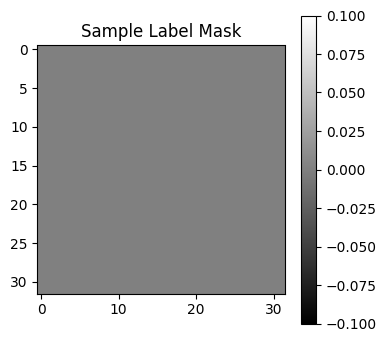

In [ ]:
# double check the label in .tif data
import matplotlib.pyplot as plt
import numpy as np

# take one batch from train_ds
for x, y in train_ds.take(1):
    sample_x = x[0].numpy()       # (32,32,18)
    sample_y = y[0].numpy()       # (32,32,1)
    break

print("x shape:", sample_x.shape)
print("y shape:", sample_y.shape)
print("y unique values:", np.unique(sample_y))

plt.figure(figsize=(4,4))
plt.imshow(sample_y[:,:,0], cmap="gray")
plt.title("Sample Label Mask")
plt.colorbar()
plt.show()


In [ ]:
# check a batch of train data to see if there exist NaN / inf
for x_batch, y_batch in train_ds.take(1):
    print("x_nan:", tf.math.reduce_any(tf.math.is_nan(x_batch)).numpy())
    print("y_nan:", tf.math.reduce_any(tf.math.is_nan(y_batch)).numpy())
    print("x_inf:", tf.math.reduce_any(tf.math.is_inf(x_batch)).numpy())
    print("y_inf:", tf.math.reduce_any(tf.math.is_inf(y_batch)).numpy())

    print("x min / max:", tf.reduce_min(x_batch).numpy(), tf.reduce_max(x_batch).numpy())
    print("y unique:", tf.unique(tf.reshape(y_batch, [-1]))[0].numpy())


x_nan: False
y_nan: False
x_inf: False
y_inf: False
x min / max: -3.5786633 7.782477
y unique: [0. 1.]


### Training

In [ ]:
import tensorflow as tf

def binary_focal_loss(gamma=1.0, alpha=0.5):

    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -(y_true * tf.math.log(y_pred) +
               (1.0 - y_true) * tf.math.log(1.0 - y_pred))
        weight = (
            alpha * y_true * tf.pow(1.0 - y_pred, gamma) +
            (1.0 - alpha) * (1.0 - y_true) * tf.pow(y_pred, gamma)
        )

        return tf.reduce_mean(weight * ce)

    return loss_fn


def dice_loss(y_true, y_pred):

    smooth = 1e-6
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (denom + smooth)


def focal_dice_loss(y_true, y_pred):
    focal = binary_focal_loss(gamma=1.5, alpha=0.9)(y_true, y_pred)
    d = dice_loss(y_true, y_pred)
    return focal + d


In [ ]:
import tensorflow as tf

# 1. load pre-trained model
backbone = build_CNN_AE_model()          # input: (32, 32, 12)
backbone.load_weights("best.h5")
print("Loaded backbone weights from best.h5")

# 2. freeze backbone
backbone.trainable = False

# 3. adapt to new 18 band input
inputs_18 = tf.keras.Input(shape=(32, 32, 18), name="input_18bands")

# 4. 18 → 12 1×1 Conv
x12 = tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=1,
    padding="same",
    name="adapter_18to12"
)(inputs_18)

# 5. 12 band throw to segmentation backbone
outputs = backbone(x12)

# 6. construct new transfer model
transfer_model = tf.keras.Model(
    inputs=inputs_18,
    outputs=outputs,
    name="wildfire_transfer_18bands"
)

# 7. compile
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_dice_loss,
    metrics=[
        IoU_metric,
        dice_metric,
        precision_metric,
        recall_metric,
    ]
)

transfer_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v2.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Loaded backbone weights from best.h5


Model: "wildfire_transfer_18bands"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_18bands (InputLayer)      │ (None, 32, 32, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adapter_18to12 (Conv2D)         │ (None, 32, 32, 12)     │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_29 (Functional)      │ (None, 32, 32, 1)      │     6,503,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,504,167 (24.81 MB)

 Trainable params: 228 (912.00 B)

 Non-trainable params: 6,503,939 (24.81 MB)

In [ ]:
# TRAINING！😄😄😄
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.h5",              # file name
    monitor="val_loss",           # assess by loss index
    save_best_only=True,          # save the best
    mode="min",
    verbose=1
)

history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint],
)


Epoch 1/20
     60/Unknown 63s 604ms/step - dice_metric: 0.0085 - io_u_metric: 0.0043 - loss: 1.1448 - precision_metric: 0.0043 - recall_metric: 0.7731

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.11150, saving model to best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 841ms/step - dice_metric: 0.0085 - io_u_metric: 0.0043 - loss: 1.1446 - precision_metric: 0.0043 - recall_metric: 0.7721 - val_dice_metric: 0.0043 - val_io_u_metric: 0.0021 - val_loss: 1.1115 - val_precision_metric: 0.0021 - val_recall_metric: 0.4748
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - dice_metric: 0.0079 - io_u_metric: 0.0040 - loss: 1.1011 - precision_metric: 0.0040 - recall_metric: 0.5147
Epoch 2: val_loss improved from 1.11150 to 1.07783, saving model to best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 991ms/step - dice_metric: 0.0079 - io_u_metric: 0.0040 - loss: 1.1010 - precision_metric: 0.0040 - recall_metric: 0.5136 - val_dice_metric: 0.0035 - val_io_u_metric: 0.0018 - val_loss: 1.0778 - val_precision_metric: 0.0018 - val_recall_metric: 0.2478
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - dice_metric: 0.0062 - io_u_metric: 0.0031 - loss: 1.0732 - precision_metric: 0.0032 - recall_metric: 0.2915
Epoch 3: val_loss improved from 1.07783 to 1.05975, saving model to best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 734ms/step - dice_metric: 0.0062 - io_u_metric: 0.0031 - loss: 1.0732 - precision_metric: 0.0031 - recall_metric: 0.2908 - val_dice_metric: 0.0030 - val_io_u_metric: 0.0015 - val_loss: 1.0597 - val_precision_metric: 0.0015 - val_recall_metric: 0.1423
Epoch 4/20
53/60 ━━━━━━━━━━━━━━━━━━━━ 4s 605ms/step - dice_metric: 0.0047 - io_u_metric: 0.0024 - loss: 1.0600 - precision_metric: 0.0024 - recall_metric: 0.1693

KeyboardInterrupt: 

## U-Net start from scratch

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x


def build_unet(input_shape=(32, 32, 18)):
    inputs = layers.Input(shape=input_shape)

    # ----- Encoder -----
    c1, p1 = encoder_block(inputs, 32)   # 32×32 → 16×16
    c2, p2 = encoder_block(p1, 64)       # 16×16 → 8×8
    c3, p3 = encoder_block(p2, 128)      # 8×8 → 4×4
    c4, p4 = encoder_block(p3, 256)      # 4×4 → 2×2

    # ----- Bottleneck -----
    bn = conv_block(p4, 512)

    # ----- Decoder -----
    d1 = decoder_block(bn, c4, 256)      # 2×2 → 4×4
    d2 = decoder_block(d1, c3, 128)      # 4×4 → 8×8
    d3 = decoder_block(d2, c2, 64)       # 8×8 → 16×16
    d4 = decoder_block(d3, c1, 32)       # 16×16 → 32×32

    # Output → pixel-level fire mask prediction
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

unet_model = build_unet()
unet_model.summary()


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │      5,216 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_24[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 64)  │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 128) │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 4, 4, 256) │    590,080 │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 2, 2, 256) │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 2, 2, 512) │  1,180,160 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 2, 2, 512) │  2,359,808 │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 4, 4, 512) │          0 │ conv2d_33[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 4, 4, 768) │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │                   │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 4, 4, 256) │  1,769,728 │ concatenate_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 4, 4, 256) │    590,080 │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,850,977 (29.95 MB)

 Trainable params: 7,850,977 (29.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))


unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_dice_loss,
    metrics=["accuracy"]
)


In [ ]:
history = unet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 125s 647ms/step - accuracy: 0.9714 - loss: 0.9884 - val_accuracy: 0.9907 - val_loss: 0.9780
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 111s 617ms/step - accuracy: 0.9836 - loss: 0.9573 - val_accuracy: 0.9849 - val_loss: 0.9778
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 112s 629ms/step - accuracy: 0.9826 - loss: 0.9559 - val_accuracy: 0.9853 - val_loss: 0.9759
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 113s 632ms/step - accuracy: 0.9827 - loss: 0.9553 - val_accuracy: 0.9861 - val_loss: 0.9760
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 637ms/step - accuracy: 0.9830 - loss: 0.9558 - val_accuracy: 0.9863 - val_loss: 0.9764
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 112s 624ms/step - accuracy: 0.9827 - loss: 0.9535 - val_accuracy: 0.9861 - val_loss: 0.9768
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 638ms/step - accuracy: 0.9828 - loss: 0.9564 - val_accuracy: 0.9872 - val_loss: 0.9748
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 116s 650ms/step - accuracy: 0.9829 -

In [ ]:
unet_model.evaluate(test_ds)

In [ ]:
import matplotlib.pyplot as plt

for x_batch, y_batch in test_ds.take(1):
    pred = unet_model.predict(x_batch)[0, :, :, 0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input band (M11)")
plt.imshow(x_batch[0, :, :, 0])

plt.subplot(1, 3, 2)
plt.title("Ground truth")
plt.imshow(y_batch[0, :, :, 0])

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred)
plt.colorbar()
plt.show()
